## Analyze whether early or late snow changes more year to year or place to place.

* We know from previous notebooks that the value of `coef_2` corresponds to whether the snow season is early or late. 
* We want to study whether early/late season is more dependent on the year or on the location.
* We will use RMS Error to quantify the strength of these dependencies.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [6]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [7]:

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
### Read the data frame from pickle file

data_dir='../Data/Weather'
state='WA'
meas='TOBS_s20'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [9]:
#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())


12066


In [7]:
tmp=df.filter(df.Station=='USC00306411').toPandas()
tmp.head(1)

,Station,Measurement,Values,Year,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,dist_coast,...,longitude,name,res_1,res_2,res_3,res_4,res_5,res_mean,total_var,State


In [21]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Features='station, year, coeff_1'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_1 FROM weather


,station,year,coeff_1
0,USC00454486,1924,124.610931
1,USC00454486,1925,-204.001132
2,USC00454486,1926,-532.205568
3,USC00454486,1927,-279.739552
4,USC00454486,1928,-311.950681


In [23]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_1')
year_station_table.tail(5)

station,USC00450008,USC00450013,USC00450094,USC00450158,USC00450176,USC00450184,USC00450217,USC00450257,USC00450456,USC00450482,...,USC00459463,USW00024237,USW00024239,USW00024240,USW00024243,USW00024244,USW00094103,USW00094197,USW00094227,USW00094290
year,,,,,,,,,,,,,,,,,,,,,
2009,535.816951,NaN,NaN,NaN,241.864408,NaN,NaN,NaN,-118.269259,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-185.674770,NaN,NaN
2010,511.074258,NaN,NaN,NaN,231.568371,NaN,NaN,NaN,-38.402246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.001837,NaN,NaN
2011,567.899423,NaN,NaN,NaN,313.188432,NaN,NaN,903.757341,154.109659,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.953880,NaN,NaN
2012,518.046016,NaN,NaN,NaN,261.686741,NaN,NaN,914.879674,-44.556097,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-31.918008
2013,-17.483920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-54.988062


Text(0,0.5,'Number of stations')

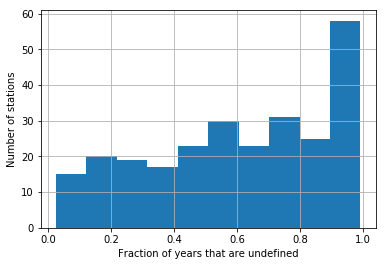

In [24]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0,0.5,'fraction of stations that are undefined')

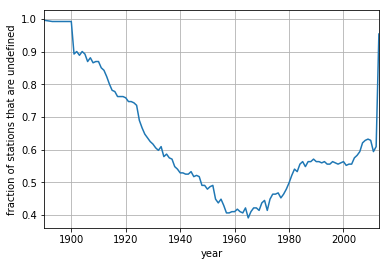

In [25]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [26]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_1')
year_station_table.tail(5)

station,USC00450008,USC00450013,USC00450158,USC00450176,USC00450184,USC00450217,USC00450257,USC00450456,USC00450482,USC00450564,...,USC00459291,USC00459327,USC00459342,USC00459376,USC00459455,USC00459463,USW00024239,USW00094197,USW00094227,USW00094290
year,,,,,,,,,,,,,,,,,,,,,
2009,535.816951,NaN,NaN,241.864408,NaN,NaN,NaN,-118.269259,NaN,NaN,...,NaN,NaN,NaN,-942.632481,-713.572378,NaN,NaN,-185.674770,NaN,NaN
2010,511.074258,NaN,NaN,231.568371,NaN,NaN,NaN,-38.402246,NaN,NaN,...,NaN,NaN,NaN,-840.579065,-644.390066,NaN,NaN,23.001837,NaN,NaN
2011,567.899423,NaN,NaN,313.188432,NaN,NaN,903.757341,154.109659,NaN,NaN,...,NaN,NaN,NaN,-719.882749,-350.997654,NaN,NaN,208.953880,NaN,NaN
2012,518.046016,NaN,NaN,261.686741,NaN,NaN,914.879674,-44.556097,NaN,NaN,...,NaN,NaN,NaN,-872.382660,-663.717894,NaN,NaN,NaN,NaN,-31.918008
2013,-17.483920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-54.988062


Text(0,0.5,'Number of stations')

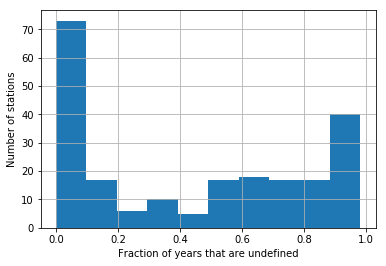

In [27]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [28]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  637.717784295
RMS removing mean-by-station=  349.481758953 reduction= 288.236025342
RMS removing mean-by-year   =  625.41883457 reduction= 12.298949725


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* We can use **alternating minimization** to remove the combined effect of location and time.

In [29]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 637.717784295
0 after removing mean by year    = 625.41883457
0 after removing mean by stations= 334.562631957
1 after removing mean by year    = 333.474559894
1 after removing mean by stations= 333.368045742
2 after removing mean by year    = 333.348758846
2 after removing mean by stations= 333.344464236
3 after removing mean by year    = 333.343445879
3 after removing mean by stations= 333.343199923
4 after removing mean by year    = 333.343140199
4 after removing mean by stations= 333.343125674


In [30]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1961    0.379054
1962    0.336415
1963    0.318321
1964    0.288477
1965    0.290162
Name: mean_by_year, dtype: float64

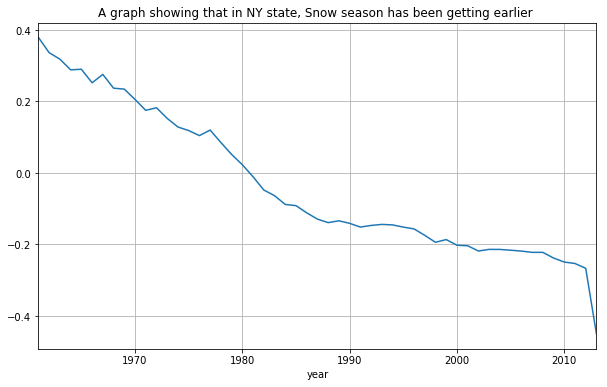

In [31]:
figure(figsize=(10,6))
T['mean_by_year'].plot();
grid()
title('A graph showing that in NY state, Snow season has been getting earlier ');

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY has been getting earlier and earlier since 1960.